# Soiaporn model

Prototype the Metropolis-within-Gibbs sampling technique presented in Soiaporn et al. 2012.

The full conditionals:

$$
F_T | f, \lambda, D \sim Gamma \bigg(N_C +1, \frac{1}{1/s + (1 - f)\epsilon_0 + f \sum_{k \geq 1} w_k \epsilon_k}\bigg)
$$

$$
P(\lambda_i | F_T, f, D) \propto \frac{f_{\lambda_i}}{\epsilon_{\lambda_i}} h_{\lambda_i}
$$

Where $h_{j} = (1 - f) \epsilon_0$ if $j = 0$ and $h_j = fw_j\epsilon_j$ if $j \geq 1$.

$$
P(f | \lambda, F_T, D) \propto e^{-F_T [  (1 - f)\epsilon_0  + f \sum_{k \geq 1} \epsilon_k w_k] } \times (1-f)^{m_0(\lambda) + b - 1}f^{N_C - m_0(\lambda)+a-1}
$$


$F_T$ and $\lambda$ are sampled directly from the gamma and multinomial distributions. $f$ is sampled using a random walk Metropolis algorithm with Gaussian proposals centred on the current value of $f$. The variance of the proposal distribution was tuned to give an acceptance rate of 25%.

$\kappa$ is treated specially, they consider a logarithmically spaced grid of values to condition on. So, treat $\kappa$ as fixed. 

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from fancy import Data
import pystan
import seaborn as sns
from metropolis_within_gibbs import *

## Set up

Define input parameters and data. NB: $A = 3000 km^2$ and $\alpha_T = 20370 km^2 sr year$ are defined in `soiaporn_functions.py`.

In [2]:
# fixed parameters
#kappa = 100
kappa_c = 9323

# hyperparametrs
a = 1 
b = 1
s = 0.01 * 4 * np.pi

In [3]:
# load data
uhecr_file = 'data/augerUHECR_data2010.dat'
source_file = 'data/agn_catalog.dat'

data = Data()
data.add_source(source_file, 'AGN')
data.add_uhecr(uhecr_file, 'Auger2010')

N_C = len(data.uhecr.energy)
theta = np.deg2rad(data.uhecr.incidence_angle)
d = data.uhecr.unit_vector
varpi = data.source.unit_vector
D = data.source.distance
period = data.uhecr.period
A = data.uhecr.A

In [4]:
# integral tables
from fancy.interfaces.integration import ExposureIntegralTable
from fancy.detector.auger import M, alpha_T, auger_params_for_M_calc
my_table_file = 'tableforfig4.data.R'

params = auger_params_for_M_calc

kappa = [10, 31.6, 100, 316, 1000]

#my_table = ExposureIntegralTable(kappa, varpi, params, filename = my_table_file)
#my_table.build()

eps = np.transpose(pystan.read_rdump(my_table_file)['table'])
eps = eps * alpha_T / M

## Recreate Fig. 4 in Soiaporn et al. 

Find the marginal posterior of $f$ for the different values of $\kappa$: [10, 31.6, 100, 316, 1000]. Use all the UHECR data.

In [5]:
sample_set = []
samplers = []
for i in range(len(kappa)):
    input_data = InputData(d, A, theta, varpi, D, eps[i])
    input_parameters = InputParameters(kappa[i], kappa_c, a, b, s)
    sampler = MetropolisWithinGibbs(input_data, input_parameters)
    sampler.Sample(Niter = 3000, Nchain = 2)
    sample_set.append(sampler.total_samples)
    samplers.append(sampler)

kappa: 10
eps [3233.64537508 2684.17070829 1078.96785757 1670.24009845 3002.47485288
 2878.94499582 2766.59095747 1107.00397187 1081.34545247  156.58025334
 3078.98620953  297.62317053 2974.37903884  123.30631603  122.50575718
 2994.47498962 3249.955904  ]
kappa: 10
eps [3233.64537508 2684.17070829 1078.96785757 1670.24009845 3002.47485288
 2878.94499582 2766.59095747 1107.00397187 1081.34545247  156.58025334
 3078.98620953  297.62317053 2974.37903884  123.30631603  122.50575718
 2994.47498962 3249.955904  ]
Sampling completed
------------------
rhat f: 1.00
rhat F_T: 1.00
accepted fraction: 0.21

kappa: 31.6
eps [3278.9362728  2795.30839371 1022.56116874 1736.72743787 3097.19244748
 2985.22356749 2876.9587315  1059.3930278  1025.69485874   17.22963295
 3160.60480702   85.74699611 3072.62561354    9.11171684    8.95246898
 3090.26115943 3293.40098738]
kappa: 31.6
eps [3278.9362728  2795.30839371 1022.56116874 1736.72743787 3097.19244748
 2985.22356749 2876.9587315  1059.3930278  1025.6

/Users/fran/projects/bayes/astroparticle/soiaporn_model/metropolis_within_gibbs/soiaporn_functions.py:85: RuntimeWarning: divide by zero encountered in log
  term2 = np.log(np.power(1 - f, m_0 + b - 1)) + np.log(np.power(f, N_C - m_0 + a - 1))


Sampling completed
------------------
rhat f: 1.01
rhat F_T: 1.01
accepted fraction: 0.26

kappa: 1000
eps [3.28497097e+03 2.84658099e+03 1.06623068e+03 1.77682554e+03
 3.14491988e+03 3.03640611e+03 2.92865928e+03 1.10461154e+03
 1.06951776e+03 5.63713407e-38 3.20292521e+03 1.88293325e-16
 3.12155372e+03 5.25084023e-47 2.92741305e-47 3.13836341e+03
 3.29107846e+03]
kappa: 1000
eps [3.28497097e+03 2.84658099e+03 1.06623068e+03 1.77682554e+03
 3.14491988e+03 3.03640611e+03 2.92865928e+03 1.10461154e+03
 1.06951776e+03 5.63713407e-38 3.20292521e+03 1.88293325e-16
 3.12155372e+03 5.25084023e-47 2.92741305e-47 3.13836341e+03
 3.29107846e+03]
Sampling completed
------------------
rhat f: 1.00
rhat F_T: 1.00
accepted fraction: 0.30



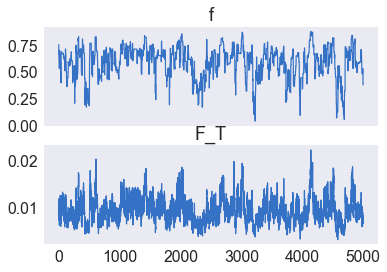

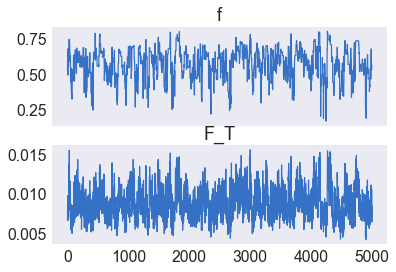

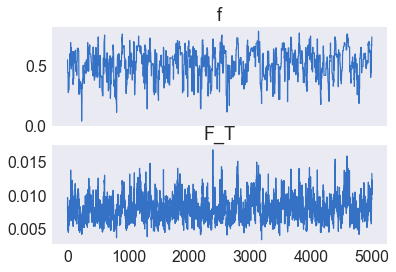

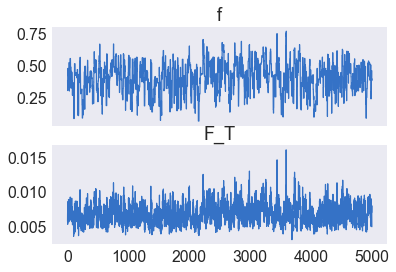

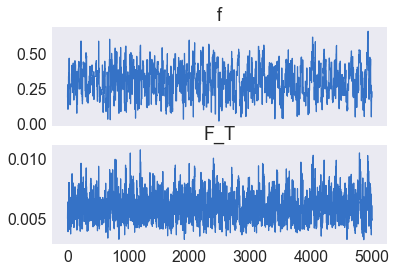

In [6]:
sns.set_style("dark")
for s in samplers:
    s.traceplot()

In [ ]:
# plot
for i in range(len(sample_set)):
    sns.distplot(sample_set[i].f, label = '$\kappa$: ' + str(kappa[i]))
plt.legend()

/Users/fran/projects/bayes/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


In [ ]:
for i in range(len(sample_set)):
    plt.scatter(sample_set[i].f, sample_set[i].F_T, alpha = 0.3)